### Anomaly Detection 
- Learning ML/Deep learning upskills with KU
- To indentify the data points that are different of the other data point
- There are 3 categories
    - Supervised Anomaly Dection: labels for both nomal and anomalous data
    - Semi-Supervised Anomaly Dectection: only label of nomal data 
    - Unsupervise Anomaly Dectection: no label is available
- Algorithms
    - Mahalanobis Distance: 
        - For one single dimension data, z-score can be used for outlier/anomaly detection. A data point is labeled as an anomaly if |z| > T (Threshold)
        - For multidimensional data, the z-score is not applicable. The Mahalanobis distance defined as https://en.wikipedia.org/wiki/Mahalanobis_distance
        
    - Density-based spatial clustering of application with noise (DBSCAN)
    - Local Outlier Factor (LOF)
    - Isolation Forest
    - One-Class Support Vector Machine

In [2]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# make dataset
from sklearn.datasets import make_blobs

# statistical modules for data generation and critical values
from scipy.stats import multivariate_normal, beta, uniform, t

from functools import partial

from sklearn import svm
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import pairwise_distances
from sklearn.covariance import EllipticEnvelope # use for Mohalanobis distance
from sklearn.cluster import DBSCAN
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.linear_model import SGDOneClassSVM

from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc

from typing import Any


In [3]:
class MahalanobisOutlier(EllipticEnvelope):

    def __init__(self, *, store_precision = True, assume_centered = False, support_fraction = None, contamination = 0.1, alpha:float = 0.05, random_state = None, ) -> None:
        super().__init__(store_precision = store_precision,
                         assume_centered = assume_centered,
                         support_fraction = support_fraction,
                         contamination = contamination,
                         random_state = random_state,)
        self.alpha = alpha

    def predict(self, X):
        dist = self.mahalanobis(X = X)
        p = self.location_.shape[0] # dimension
        n = self.support_.shape[0] # number of sample

        if p > 1:
            Tm = ((n - 1) ** 2)/n
            alpha = self.alpha
            b = beta.ppf(1 - alpha, a = p/2, b = (n - p - 1)/2) # return quantile corresponding to the lower tail probability
            Tm = Tm * b
            inliers = 2 * (dist <= Tm).astype('int') - 1 # -1v for anomalies/outliers, +1 for inliers
        else: # one dimension use Gubb's test
            Tm = ((n - 1) ** 2)/n
            t_sq = t.ppf(1 - alpha/2.0, df = n - 2) ** 2
            th = t_sq/(n - 2 - t_sq)
            Tm = Tm * th
            inliers = 2 * (dist <= Tm).astype('int') - 1
        return inliers
    
    def decision_func(self, X:np.ndarray) -> np.ndarray:
        p = self.location_.shape[0] # dimension
        n = self.support_.shape[0] # number of sample

        if p > 1:
            Tm = ((n - 1) ** 2)/n
            alpha = self.alpha
            b = beta.ppf(1 - alpha, a = p/2, b = (n - p - 1)/2) # return quantile corresponding to the lower tail probability
            Tm = Tm * b
        else: # one dimension use Gubb's test
            Tm = (n - 1)/np.sqrt(n)
            t_sq = t.ppf(1 - alpha/2.0, df = n - 2) ** 2
            th = np.sqrt(t_sq/(n - 2 - t_sq))
            Tm = Tm * th
        score = -self.mahalanobis(X = X) + Tm
        return score           
    

In [4]:
# alpha: The significace value for detecting anomaly
# contamination: The portion of training data that may be outlier or anormalies

alpha = 0.01
contamination = 0.01

clf = MahalanobisOutlier(contamination = contamination, alpha = alpha)

In [5]:
clf

MahalanobisOutlier(alpha=0.01, contamination=0.01)

In [6]:
# Unimodal data with single anomaly
# create a dataset that have points from a single multivariate Gaussion population, then manually add a outlier into a dataset

np.random.seed(0) # random seed = 0
n = 1000 # 1000 samples
mu = np.array([0, 0]) # zero means
sigma = np.array([
    [2, 1],
    [1, 2]
])
sigma

array([[2, 1],
       [1, 2]])

In [7]:
sigma.shape

(2, 2)

In [8]:
normal = multivariate_normal.rvs(mean = mu, cov = sigma, size = n) # rvs: random variates of size (size, N), where N is the dimension of the random variable
normal

array([[-2.44346794, -1.87756019],
       [-2.7832551 ,  0.38584645],
       [-1.59624225, -2.97832189],
       ...,
       [-0.31140929, -0.17316878],
       [-1.82853826, -1.60447897],
       [ 2.32553395,  0.47154187]])

In [9]:
len(normal)

1000

In [10]:
anomaly = np.array([3, 3])
anomaly

array([3, 3])

In [11]:
anomaly = np.array([3, 3]).reshape(-1, 2) # anomaly data popint
anomaly

array([[3, 3]])

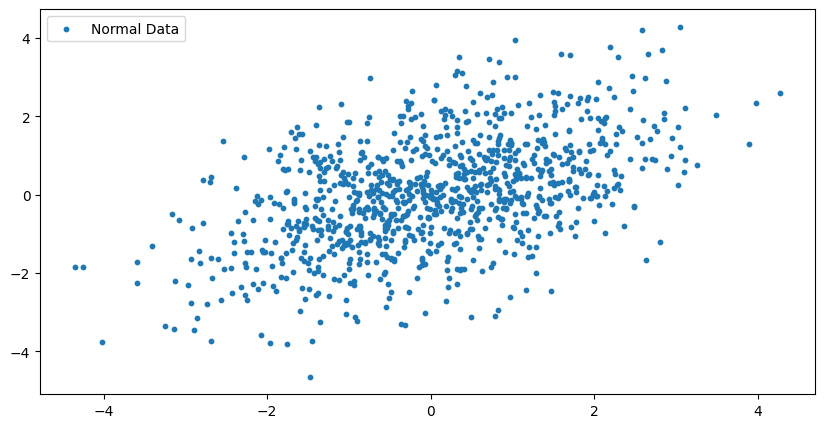

In [12]:
fig, ax = plt.subplots(1, 1, figsize = (10, 5))
ax.scatter(normal[:, 0], normal[:, 1], s = 10, label = 'Normal Data')

ax.legend()

Text(0.5, 1.0, 'Unimodal Data with Single Anomaly')

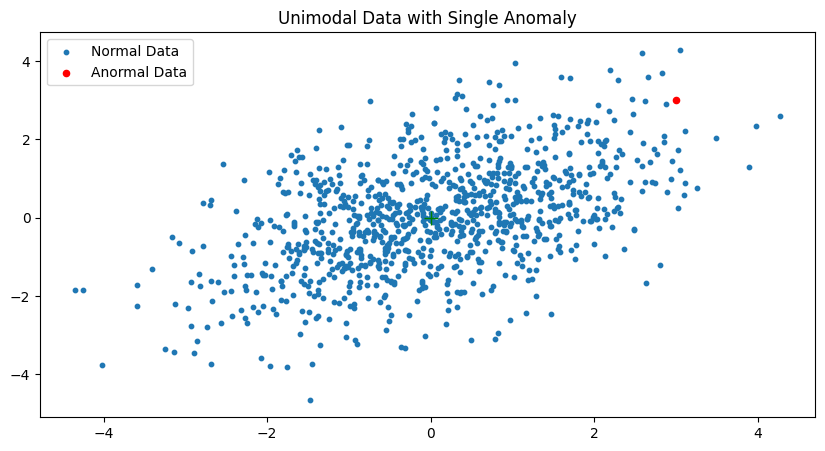

In [13]:
fig, ax = plt.subplots(1, 1, figsize = (10, 5))
ax.scatter(normal[:, 0], normal[:, 1], s = 10, label = 'Normal Data')
ax.plot([0], [0], marker = '+', color = 'green', markersize = 10) # mark the center
ax.scatter(anomaly[:, 0], anomaly[:, 1], s = 20, color = 'red', label = 'Anormal Data') # add anomaly data point

ax.legend()
ax.set_title('Unimodal Data with Single Anomaly')

In [14]:
# concate normal and anomaly together

dataset1 = np.concatenate((normal, anomaly)) # last item is the anomaly
dataset1

array([[-2.44346794, -1.87756019],
       [-2.7832551 ,  0.38584645],
       [-1.59624225, -2.97832189],
       ...,
       [-1.82853826, -1.60447897],
       [ 2.32553395,  0.47154187],
       [ 3.        ,  3.        ]])

In [15]:
# create labels: 0 for nomal, 1 for anomaly

label = np.concatenate([(np.zeros(n, )), np.ones(1, )])  # last item is the anomaly
label

array([0., 0., 0., ..., 0., 0., 1.])

In [16]:
len(label)

1001

In [17]:
# setting for Mahalanobis Distance for Anomaly Detection

alpha = 0.001 # significance level for detecting anomalies
contamination = 0.001 # portion of anomalies in the training data

In [18]:
# create the model

clf_mahal = MahalanobisOutlier(contamination = contamination, alpha = alpha, random_state = 0) # set the random state to get the same result
clf_mahal

MahalanobisOutlier(alpha=0.001, contamination=0.001, random_state=0)

In [19]:
# train/fit the model

clf_mahal.fit(dataset1)

MahalanobisOutlier(alpha=0.001, contamination=0.001, random_state=0)

In [20]:
# Decision boundary and anomaly output

dataset = dataset1
normal_data = normal
anomaly_data = anomaly

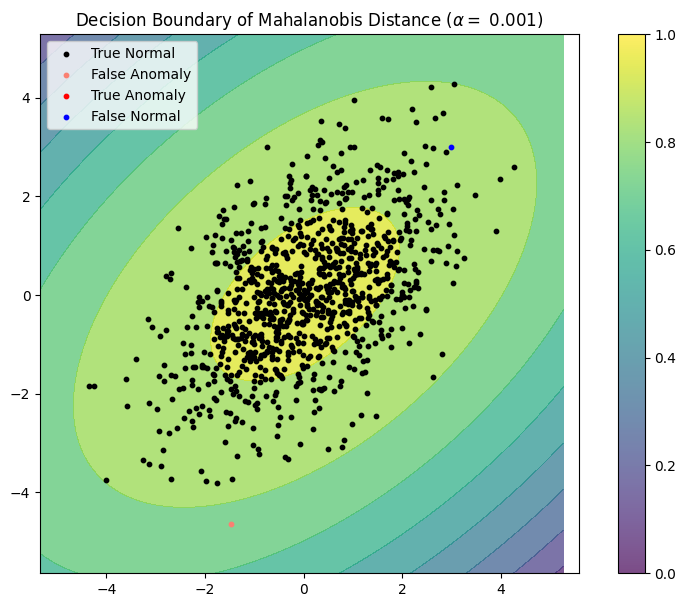

In [21]:
fig, ax = plt.subplots(1, 1, figsize = (10, 7)) # make subplot of size 10x5

disp = DecisionBoundaryDisplay.from_estimator(clf_mahal, # anomaly detector
                                              dataset, # dataset for drawing decision boundary
                                              response_method = "decision_function", # plot decision function
                                              alpha = 0.7, # transparent level
                                              ax = ax)

pred = clf_mahal.predict(normal_data) # predict 
disp.ax_.scatter(normal_data[pred == 1, 0], normal_data[pred == 1, 1], s = 10, color = 'black', label = "True Normal")
disp.ax_.scatter(normal_data[pred == -1, 0], normal_data[pred == -1, 1], s = 10, color = 'salmon', label = "False Anomaly")

preda = clf_mahal.predict(anomaly_data) # predict 
disp.ax_.scatter(anomaly_data[preda == -1, 0], anomaly_data[preda == -1, 1], s = 10, color = 'red', label = "True Anomaly")
disp.ax_.scatter(anomaly_data[preda == 1, 0], anomaly_data[preda == 1, 1], s = 10, color = 'blue', label = "False Normal")

disp.ax_.set_title(r"Decision Boundary of Mahalanobis Distance ($\alpha=$ {})".format(alpha))
plt.axis("Square")
plt.colorbar(disp.ax_.collections[1])
plt.legend();

In [22]:
# Performance evaluation

pred = clf_mahal.predict(dataset1)
pred

array([1, 1, 1, ..., 1, 1, 1])

In [23]:
len(pred)

1001

In [24]:
pred[-1]

1

In [25]:
pred = 1 - ((pred + 1)/2).astype('int') # convert 1 -> 0, -1 -> 1
pred

array([0, 0, 0, ..., 0, 0, 0])

In [26]:
target_names = ['Nomal', 'Anomaly']

print("Classification Report of Mahalanobis Distance Anomaly Detection Algorithm")
print(classification_report(label, pred, target_names = target_names))

Classification Report of Mahalanobis Distance Anomaly Detection Algorithm
              precision    recall  f1-score   support

       Nomal       1.00      1.00      1.00      1000
     Anomaly       0.00      0.00      0.00         1

    accuracy                           1.00      1001
   macro avg       0.50      0.50      0.50      1001
weighted avg       1.00      1.00      1.00      1001



In [27]:
# Unimodal data surrounded by Anomalies
# create a dataset which the data points are derived from a single multivariate Gaussian  population. Oulier are added as the extreme outlier.

np.random.seed(0) # set for consistance run
n = 10_000
n

10000

In [28]:
n_normal = int(n * 0.98)
n_normal

9800

In [29]:
n_anomaly = n - n_normal
n_anomaly

200

In [30]:
normal2, _ = make_blobs(n_samples = n_normal, n_features = 2, centers = [[0, 0]], cluster_std = [1.0])
normal2

array([[ 2.1720921 , -0.14620691],
       [-1.13092728, -0.16036191],
       [-0.76381983,  0.30792253],
       ...,
       [ 0.94327374,  0.30047837],
       [ 0.04968522, -1.60184875],
       [-1.18709247,  0.65935716]])

In [31]:
len(normal2)

9800

In [32]:
# anomalies are located on the circle of radius r = 4 centered at the origin
 
r = 4
theta = np.arange(n_anomaly) * (2 * np.pi * n_anomaly) # 2% anomaly rate
theta

array([     0.        ,   1256.63706144,   2513.27412287,   3769.91118431,
         5026.54824574,   6283.18530718,   7539.82236862,   8796.45943005,
        10053.09649149,  11309.73355292,  12566.37061436,  13823.0076758 ,
        15079.64473723,  16336.28179867,  17592.9188601 ,  18849.55592154,
        20106.19298297,  21362.83004441,  22619.46710585,  23876.10416728,
        25132.74122872,  26389.37829015,  27646.01535159,  28902.65241303,
        30159.28947446,  31415.9265359 ,  32672.56359733,  33929.20065877,
        35185.83772021,  36442.47478164,  37699.11184308,  38955.74890451,
        40212.38596595,  41469.02302739,  42725.66008882,  43982.29715026,
        45238.93421169,  46495.57127313,  47752.20833456,  49008.845396  ,
        50265.48245744,  51522.11951887,  52778.75658031,  54035.39364174,
        55292.03070318,  56548.66776462,  57805.30482605,  59061.94188749,
        60318.57894892,  61575.21601036,  62831.8530718 ,  64088.49013323,
        65345.12719467,  

In [33]:
len(theta)

200

In [34]:
x = np.cos(theta) * r + np.random.randn(n_anomaly) * r * 0.1
x

array([4.13824916, 3.86209803, 3.91090796, 3.15698466, 3.48906472,
       3.98200253, 4.49630777, 3.78520134, 3.75997755, 3.94043495,
       3.64156799, 3.68919321, 3.86324671, 4.03288218, 3.86461181,
       3.57331502, 4.20043556, 4.36841824, 3.97690262, 3.71805384,
       4.51583389, 4.05435159, 3.8484569 , 3.66020798, 4.44906376,
       4.31800552, 4.24419883, 4.21461297, 3.92152417, 3.52482017,
       3.53205322, 3.77134917, 4.26828343, 4.09751009, 3.22297486,
       4.38929806, 4.02417454, 3.57583833, 4.40610443, 3.58453322,
       4.52878889, 4.07839154, 3.67697688, 3.42537398, 4.7922005 ,
       3.7081905 , 4.40763529, 3.07682376, 4.52112761, 3.85696596,
       4.07350707, 3.8835773 , 4.38965104, 4.33158797, 4.11820714,
       4.03774096, 3.55711867, 3.68175037, 3.62237363, 4.15689317,
       3.6257309 , 4.02811074, 3.48329757, 4.003898  , 3.64754184,
       4.38115689, 3.97226408, 3.63172419, 4.33083697, 4.4628217 ,
       4.15928518, 4.43082953, 3.71974069, 3.97610658, 4.13131

In [35]:
len(x)

200

In [36]:
y = np.sin(theta) * r + np.random.randn(n_anomaly) * r * 0.1
y

array([-0.7484382 , -0.06345132, -0.0324438 , -0.38272528, -0.23739723,
        0.6504494 , -0.11917175,  0.05130609,  0.38713665,  0.12574708,
       -0.110413  ,  0.10834949,  0.08734993,  0.1984614 , -0.03478346,
        0.65298901, -0.6562069 , -1.18765655,  0.53401657,  0.34781761,
       -0.076691  ,  0.16932873,  0.95066974, -0.27267265, -0.56449135,
       -0.56489535, -0.31702201, -0.05400069, -0.53660312, -0.32749463,
       -0.47702724, -0.01844818, -0.02428687,  0.10261947,  0.07018698,
        0.52185801, -0.48134485, -0.65163092,  0.05181227, -0.12425454,
       -0.17290319,  0.56461834, -0.0099415 ,  0.19555729,  0.58928546,
       -0.37058196, -0.23489665, -0.09319964,  0.67289334, -0.8022579 ,
        0.47374182, -0.06368523,  0.38707474, -1.05389026,  0.44764915,
        0.1599077 ,  0.85317581,  0.42061626, -0.25958429, -0.06026753,
       -0.0089972 , -0.39973904, -0.32199238,  0.40928928,  0.00688129,
       -0.22244326, -1.05574711,  0.47097882, -1.02697921,  0.34

In [37]:
len(y)

200

In [38]:
anomaly2 = np.stack((x, y), axis = 0)
anomaly2

array([[ 4.13824916e+00,  3.86209803e+00,  3.91090796e+00,
         3.15698466e+00,  3.48906472e+00,  3.98200253e+00,
         4.49630777e+00,  3.78520134e+00,  3.75997755e+00,
         3.94043495e+00,  3.64156799e+00,  3.68919321e+00,
         3.86324671e+00,  4.03288218e+00,  3.86461181e+00,
         3.57331502e+00,  4.20043556e+00,  4.36841824e+00,
         3.97690262e+00,  3.71805384e+00,  4.51583389e+00,
         4.05435159e+00,  3.84845690e+00,  3.66020798e+00,
         4.44906376e+00,  4.31800552e+00,  4.24419883e+00,
         4.21461297e+00,  3.92152417e+00,  3.52482017e+00,
         3.53205322e+00,  3.77134917e+00,  4.26828343e+00,
         4.09751009e+00,  3.22297486e+00,  4.38929806e+00,
         4.02417454e+00,  3.57583833e+00,  4.40610443e+00,
         3.58453322e+00,  4.52878889e+00,  4.07839154e+00,
         3.67697688e+00,  3.42537398e+00,  4.79220050e+00,
         3.70819050e+00,  4.40763529e+00,  3.07682376e+00,
         4.52112761e+00,  3.85696596e+00,  4.07350707e+0

In [39]:
len(anomaly2)

2

In [40]:
anomaly2.shape

(2, 200)

In [41]:
anomaly2 = np.stack((x, y), axis = 0).T
anomaly2

array([[ 4.13824916e+00, -7.48438196e-01],
       [ 3.86209803e+00, -6.34513221e-02],
       [ 3.91090796e+00, -3.24437993e-02],
       [ 3.15698466e+00, -3.82725275e-01],
       [ 3.48906472e+00, -2.37397226e-01],
       [ 3.98200253e+00,  6.50449400e-01],
       [ 4.49630777e+00, -1.19171750e-01],
       [ 3.78520134e+00,  5.13060913e-02],
       [ 3.75997755e+00,  3.87136651e-01],
       [ 3.94043495e+00,  1.25747077e-01],
       [ 3.64156799e+00, -1.10413001e-01],
       [ 3.68919321e+00,  1.08349488e-01],
       [ 3.86324671e+00,  8.73499315e-02],
       [ 4.03288218e+00,  1.98461405e-01],
       [ 3.86461181e+00, -3.47834627e-02],
       [ 3.57331502e+00,  6.52989012e-01],
       [ 4.20043556e+00, -6.56206898e-01],
       [ 4.36841824e+00, -1.18765655e+00],
       [ 3.97690262e+00,  5.34016570e-01],
       [ 3.71805384e+00,  3.47817609e-01],
       [ 4.51583389e+00, -7.66910040e-02],
       [ 4.05435159e+00,  1.69328725e-01],
       [ 3.84845690e+00,  9.50669739e-01],
       [ 3.

In [42]:
len(anomaly2)

200

In [43]:
anomaly2.shape

(200, 2)

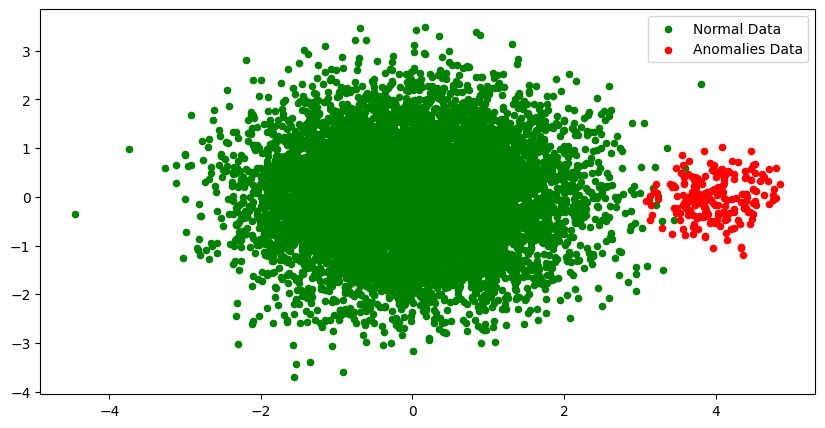

In [44]:
# plot

plt.figure(figsize = (10, 5))
plt.scatter(normal2[:, 0], normal2[:, 1], s = 20, color = 'green', label = 'Normal Data')
plt.scatter(anomaly2[:, 0], anomaly2[:, 1], s = 20, color = 'red', label = 'Anomalies Data')
plt.legend();

In [45]:
# concate nomal and anomalies data

dataset2 = np.concatenate((normal2, anomaly2))
dataset2

array([[ 2.1720921 , -0.14620691],
       [-1.13092728, -0.16036191],
       [-0.76381983,  0.30792253],
       ...,
       [ 4.48989903,  0.16155138],
       [ 3.48682331,  0.01510058],
       [ 3.87422017, -0.26189921]])

In [46]:
len(dataset2)

10000

In [47]:
label2 = np.concatenate([(np.zeros(n_normal, )), np.ones(n_anomaly, )]) # set 0 for normal and 1 for anomaly
label2

array([0., 0., 0., ..., 1., 1., 1.])

In [48]:
len(label2)

10000

In [49]:
# setting for Mahalanobis Distance for Anomaly Detection

alpha = 0.02 # significance level for detecting anomalies
contamination = 0.0001 # portion of anomalies in the training data

In [50]:
clf_mahal = MahalanobisOutlier(alpha = alpha, contamination = contamination)
clf_mahal

MahalanobisOutlier(alpha=0.02, contamination=0.0001)

In [51]:
# train/fit with dataset2

clf_mahal.fit(dataset2)

MahalanobisOutlier(alpha=0.02, contamination=0.0001)

In [52]:
# Decision boundary and anomaly output

dataset = dataset2
normal_data = normal2
anomaly_data = anomaly2

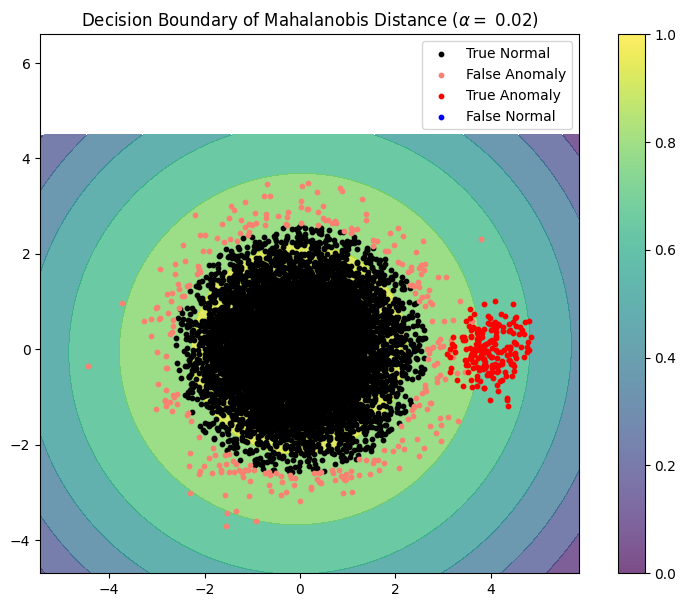

In [53]:
fig, ax = plt.subplots(1, 1, figsize = (10, 7)) # make subplot of size 10x5

disp = DecisionBoundaryDisplay.from_estimator(clf_mahal, # anomaly detector
                                              dataset, # dataset for drawing decision boundary
                                              response_method = "decision_function", # plot decision function
                                              alpha = 0.7, # transparent level
                                              ax = ax)

pred = clf_mahal.predict(normal_data) # predict 
disp.ax_.scatter(normal_data[pred == 1, 0], normal_data[pred == 1, 1], s = 10, color = 'black', label = "True Normal")
disp.ax_.scatter(normal_data[pred == -1, 0], normal_data[pred == -1, 1], s = 10, color = 'salmon', label = "False Anomaly")

preda = clf_mahal.predict(anomaly_data) # predict 
disp.ax_.scatter(anomaly_data[preda == -1, 0], anomaly_data[preda == -1, 1], s = 10, color = 'red', label = "True Anomaly")
disp.ax_.scatter(anomaly_data[preda == 1, 0], anomaly_data[preda == 1, 1], s = 10, color = 'blue', label = "False Normal")

disp.ax_.set_title(r"Decision Boundary of Mahalanobis Distance ($\alpha=$ {})".format(alpha))
plt.axis("Square")
plt.colorbar(disp.ax_.collections[1])
plt.legend();

In [54]:
# Performance evaluation

pred = clf_mahal.predict(dataset2)
pred = 1 - ((pred + 1)/2).astype('int') # convert 1 -> 0, -1 -> 1
target_names = ['Nomal', 'Anomaly']

print("Classification Report of Mahalanobis Distance Anomaly Detection Algorithm")
print(classification_report(label2, pred, target_names = target_names))

Classification Report of Mahalanobis Distance Anomaly Detection Algorithm
              precision    recall  f1-score   support

       Nomal       1.00      0.97      0.98      9800
     Anomaly       0.41      1.00      0.58       200

    accuracy                           0.97     10000
   macro avg       0.70      0.99      0.78     10000
weighted avg       0.99      0.97      0.98     10000



In [55]:
# ROC

scores = -clf_mahal.decision_function(dataset2)
scores

array([-20.3115203 , -24.18330755, -24.84567907, ...,  -3.36986945,
       -12.16536743,  -8.9104923 ])

In [56]:
len(scores)

10000

In [57]:
fpr, tpr, _ = roc_curve(y_true = label2, y_score = scores, pos_label = 1)
fpr

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.04081633e-04,
       2.04081633e-04, 3.06122449e-04, 3.06122449e-04, 4.08163265e-04,
       4.08163265e-04, 5.10204082e-04, 5.10204082e-04, 6.12244898e-04,
       6.12244898e-04, 7.14285714e-04, 7.14285714e-04, 8.16326531e-04,
       8.16326531e-04, 9.18367347e-04, 9.18367347e-04, 1.02040816e-03,
       1.02040816e-03, 1.12244898e-03, 1.12244898e-03, 1.22448980e-03,
       1.22448980e-03, 1.32653061e-03, 1.32653061e-03, 1.42857143e-03,
       1.42857143e-03, 1.53061224e-03, 1.53061224e-03, 1.93877551e-03,
       1.93877551e-03, 2.14285714e-03, 2.14285714e-03, 2.34693878e-03,
       2.34693878e-03, 2.44897959e-03, 2.44897959e-03, 3.36734694e-03,
       3.36734694e-03, 4.89795918e-03, 4.89795918e-03, 5.30612245e-03,
       5.30612245e-03, 5.61224490e-03, 5.61224490e-03, 5.81632653e-03,
       5.81632653e-03, 6.12244898e-03, 6.12244898e-03, 7.04081633e-03,
       7.04081633e-03, 8.57142857e-03, 8.57142857e-03, 1.00000000e+00])

In [58]:
tpr

array([0.   , 0.005, 0.165, 0.165, 0.42 , 0.42 , 0.625, 0.625, 0.66 ,
       0.66 , 0.665, 0.665, 0.685, 0.685, 0.775, 0.775, 0.79 , 0.79 ,
       0.83 , 0.83 , 0.84 , 0.84 , 0.85 , 0.85 , 0.875, 0.875, 0.895,
       0.895, 0.9  , 0.9  , 0.92 , 0.92 , 0.935, 0.935, 0.94 , 0.94 ,
       0.945, 0.945, 0.95 , 0.95 , 0.955, 0.955, 0.96 , 0.96 , 0.965,
       0.965, 0.97 , 0.97 , 0.98 , 0.98 , 0.985, 0.985, 0.995, 0.995,
       1.   , 1.   ])

In [59]:
_

array([  1.3532265 ,   0.3532265 ,  -3.77978536,  -3.95831809,
        -7.3854227 ,  -7.43057758,  -9.12708757,  -9.14858566,
        -9.58125837,  -9.59343456,  -9.62685535,  -9.64133289,
        -9.87284377,  -9.8811823 , -10.49051479, -10.52983262,
       -10.67648194, -10.68877401, -10.92108739, -10.9646014 ,
       -11.07612089, -11.07779039, -11.16614345, -11.19187771,
       -11.37525418, -11.46894393, -11.5304439 , -11.58901147,
       -11.70160534, -11.79052708, -12.04870101, -12.15109665,
       -12.35795835, -12.48667111, -12.50043019, -12.52308044,
       -12.61313998, -12.65190894, -12.77469405, -13.01367781,
       -13.0654457 , -13.91057742, -13.94110706, -14.01103314,
       -14.11339089, -14.13808738, -14.15313487, -14.2786511 ,
       -14.35625915, -14.41128275, -14.41747481, -14.57827015,
       -14.68540626, -15.09773688, -15.10109307, -25.57771809])

In [60]:
auc_score = auc(fpr, tpr)
auc_score

0.9992647959183674

[]

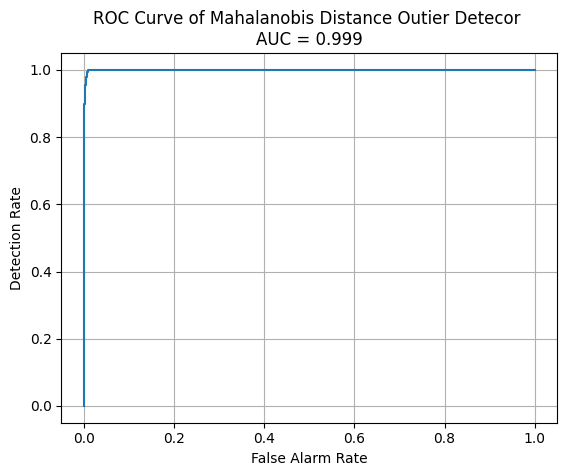

In [61]:
plt.plot(fpr, tpr)
plt.title(f"ROC Curve of Mahalanobis Distance Outier Detecor \nAUC = {auc_score:0.3f}")
plt.grid()
plt.xlabel("False Alarm Rate")
plt.ylabel("Detection Rate")
plt.plot()

In [77]:
# Dataset 3: Multimodal Data --> Generate 5 cluster of normal data centered on the circle of radious r from the origin. The anomalies are centered on the origin.

# setting

r = 4
np.random.seed(10)

n = 10_000 # 10000
n_normal = int(n * 0.95) # 9500
n_anomaly = n - n_normal # 500

angles = np.arange(5) * np.pi * (2/5)
angles

array([0.        , 1.25663706, 2.51327412, 3.76991118, 5.02654825])

In [78]:
len(angles)

5

In [79]:
# anomalies are located on the circle of radius r = 4 centered at the origin

theta = np.arange(n_anomaly) * (2 * np.pi * n_anomaly) # 2% anomaly rate
theta

array([      0.        ,    3141.59265359,    6283.18530718,
          9424.77796077,   12566.37061436,   15707.96326795,
         18849.55592154,   21991.14857513,   25132.74122872,
         28274.33388231,   31415.9265359 ,   34557.51918949,
         37699.11184308,   40840.70449667,   43982.29715026,
         47123.88980385,   50265.48245744,   53407.07511103,
         56548.66776462,   59690.26041821,   62831.8530718 ,
         65973.44572539,   69115.03837898,   72256.63103257,
         75398.22368616,   78539.81633974,   81681.40899333,
         84823.00164692,   87964.59430051,   91106.1869541 ,
         94247.77960769,   97389.37226128,  100530.96491487,
        103672.55756846,  106814.15022205,  109955.74287564,
        113097.33552923,  116238.92818282,  119380.52083641,
        122522.11349   ,  125663.70614359,  128805.29879718,
        131946.89145077,  135088.48410436,  138230.07675795,
        141371.66941154,  144513.26206513,  147654.85471872,
        150796.44737231,

In [80]:
len(theta)

500

In [81]:
theta.shape

(500,)

In [82]:
centers = [[r * np.cos(theta), r * np.sin(theta)] for theta in angles]
centers

[[4.0, 0.0],
 [1.2360679774997898, 3.804226065180614],
 [-3.2360679774997894, 2.351141009169893],
 [-3.23606797749979, -2.351141009169892],
 [1.236067977499789, -3.8042260651806146]]

In [83]:
len(centers)

5

In [84]:
normal3, _ = make_blobs(n_samples = n_normal, n_features = 2, centers = centers, cluster_std = [0.7] * len(angles))
normal3

array([[ 0.38993038,  4.50136972],
       [-3.35637456, -3.20008126],
       [-3.65261135, -1.08788993],
       ...,
       [-3.97862725, -1.67776317],
       [ 3.29881825, -0.36985484],
       [-2.98149568,  2.61156452]])

In [85]:
len(normal3)

9500

In [86]:
normal3.shape

(9500, 2)

In [87]:
anomaly3, _ = make_blobs(n_samples = n_anomaly, n_features = 2, centers = [[0, 0]], cluster_std = [0.7])
anomaly3

array([[ 7.74864980e-01,  1.12209329e-01],
       [ 4.28909956e-01,  4.11039242e-01],
       [ 5.48261870e-01,  1.01851689e+00],
       [ 1.39549540e+00, -3.51712940e-01],
       [ 7.15130831e-01,  1.68592327e+00],
       [-9.91399705e-02,  3.57998053e-02],
       [-5.10187715e-01,  1.50756747e+00],
       [ 9.19038414e-02, -2.83156735e-02],
       [-7.02149466e-02, -1.69669694e-01],
       [ 7.80723189e-01, -6.47691022e-01],
       [-6.50660285e-01, -8.80575619e-01],
       [ 1.93574643e-02,  1.66039505e-01],
       [ 9.85043281e-02,  2.65780533e-01],
       [ 7.20024004e-01, -1.27060408e+00],
       [ 1.15805895e+00,  3.02464152e-01],
       [-5.08193557e-01,  8.95439051e-02],
       [ 3.52917075e-02,  1.68484979e-01],
       [ 4.32224497e-01,  1.07737564e+00],
       [-2.80890917e-01, -3.07314113e-01],
       [-3.76486882e-01, -4.67220105e-02],
       [-6.44859643e-01,  6.86371922e-01],
       [-8.87963691e-01, -1.36478231e+00],
       [-9.76367806e-01, -9.03046686e-01],
       [-8.

In [88]:
len(anomaly3)

500

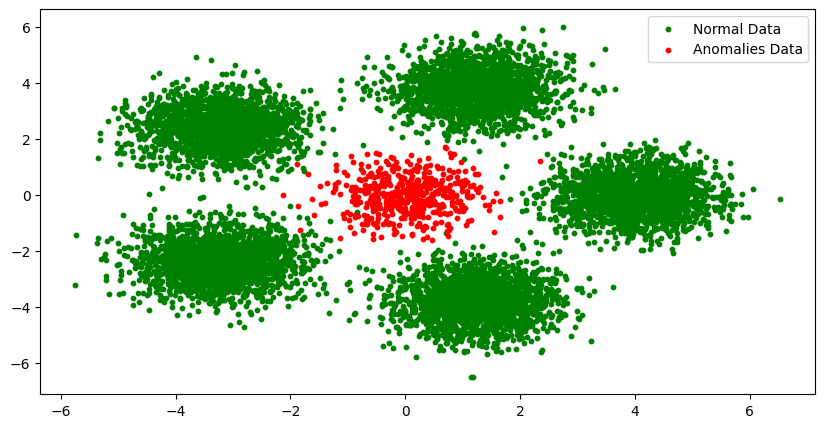

In [89]:
# plot

plt.figure(figsize = (10, 5))
plt.scatter(normal3[:, 0], normal3[:, 1], s = 10, color = 'green', label = 'Normal Data')
plt.scatter(anomaly3[:, 0], anomaly3[:, 1], s = 10, color = 'red', label = 'Anomalies Data')
plt.legend();

In [90]:
# concate nomal and anomalies data

dataset3 = np.concatenate((normal3, anomaly3)) 
dataset3

array([[ 0.38993038,  4.50136972],
       [-3.35637456, -3.20008126],
       [-3.65261135, -1.08788993],
       ...,
       [-0.45693838,  0.30588654],
       [-1.47482213, -0.33607115],
       [ 1.0964321 , -0.93239691]])

In [91]:
len(dataset3)

10000

In [92]:
label3 = np.concatenate([(np.zeros(n_normal, )), np.ones(n_anomaly, )]) # set 0 for normal and 1 for anomaly
label3

array([0., 0., 0., ..., 1., 1., 1.])

In [93]:
len(label3)

10000

In [94]:
# setting for Mahalanobis Distance for Anomaly Detection

alpha = 0.05 # significance level for detecting anomalies
contamination = 0.05 # portion of anomalies in the training data

In [95]:
clf_mahal = MahalanobisOutlier(alpha = alpha, contamination = contamination)
clf_mahal

MahalanobisOutlier(contamination=0.05)

In [96]:
# train/fit with dataset2

clf_mahal.fit(dataset3)

MahalanobisOutlier(contamination=0.05)

In [97]:
# Decision boundary and anomaly output

dataset = dataset3
normal_data = normal3
anomaly_data = anomaly3

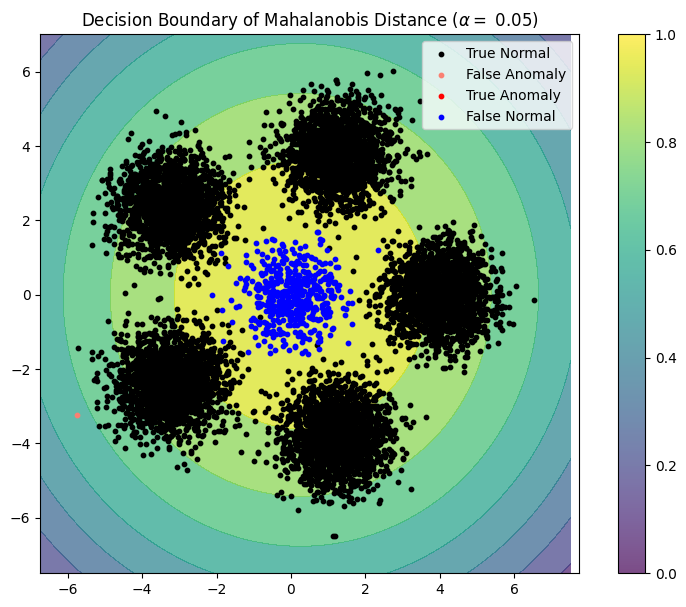

In [98]:
fig, ax = plt.subplots(1, 1, figsize = (10, 7)) # make subplot of size 10x5

disp = DecisionBoundaryDisplay.from_estimator(clf_mahal, # anomaly detector
                                              dataset, # dataset for drawing decision boundary
                                              response_method = "decision_function", # plot decision function
                                              alpha = 0.7, # transparent level
                                              ax = ax)

pred = clf_mahal.predict(normal_data) # predict 
disp.ax_.scatter(normal_data[pred == 1, 0], normal_data[pred == 1, 1], s = 10, color = 'black', label = "True Normal")
disp.ax_.scatter(normal_data[pred == -1, 0], normal_data[pred == -1, 1], s = 10, color = 'salmon', label = "False Anomaly")

preda = clf_mahal.predict(anomaly_data) # predict 
disp.ax_.scatter(anomaly_data[preda == -1, 0], anomaly_data[preda == -1, 1], s = 10, color = 'red', label = "True Anomaly")
disp.ax_.scatter(anomaly_data[preda == 1, 0], anomaly_data[preda == 1, 1], s = 10, color = 'blue', label = "False Normal")

disp.ax_.set_title(r"Decision Boundary of Mahalanobis Distance ($\alpha=$ {})".format(alpha))
plt.axis("Square")
plt.colorbar(disp.ax_.collections[1])
plt.legend();

In [99]:
# Performance evaluation

pred = clf_mahal.predict(dataset3)
pred = 1 - ((pred + 1)/2).astype('int') # convert 1 -> 0, -1 -> 1
target_names = ['Nomal', 'Anomaly']

print("Classification Report of Mahalanobis Distance Anomaly Detection Algorithm")
print(classification_report(label2, pred, target_names = target_names))

Classification Report of Mahalanobis Distance Anomaly Detection Algorithm
              precision    recall  f1-score   support

       Nomal       0.98      1.00      0.99      9800
     Anomaly       0.00      0.00      0.00       200

    accuracy                           0.98     10000
   macro avg       0.49      0.50      0.49     10000
weighted avg       0.96      0.98      0.97     10000



In [100]:
# ROC

scores = -clf_mahal.decision_function(dataset3)
scores

array([-1.10097754, -0.54817357, -1.34496318, ..., -3.50002867,
       -3.15650121, -3.38298088])

In [101]:
len(scores)

10000

In [102]:
fpr, tpr, _ = roc_curve(y_true = label3, y_score = scores, pos_label = 1)
fpr

array([0.00000000e+00, 1.05263158e-04, 9.87052632e-01, 9.87052632e-01,
       9.87263158e-01, 9.87263158e-01, 9.88421053e-01, 9.88421053e-01,
       9.94631579e-01, 9.94631579e-01, 9.95894737e-01, 9.95894737e-01,
       9.96947368e-01, 9.96947368e-01, 9.97684211e-01, 9.97684211e-01,
       9.98421053e-01, 9.98421053e-01, 9.98947368e-01, 9.98947368e-01,
       9.99052632e-01, 9.99052632e-01, 9.99157895e-01, 9.99157895e-01,
       9.99263158e-01, 9.99263158e-01, 9.99473684e-01, 9.99473684e-01,
       9.99578947e-01, 9.99578947e-01, 9.99684211e-01, 9.99684211e-01,
       9.99789474e-01, 9.99789474e-01, 9.99894737e-01, 9.99894737e-01,
       1.00000000e+00, 1.00000000e+00])

In [103]:
tpr

array([0.   , 0.   , 0.   , 0.004, 0.004, 0.006, 0.006, 0.008, 0.008,
       0.01 , 0.01 , 0.012, 0.012, 0.014, 0.014, 0.016, 0.016, 0.018,
       0.018, 0.02 , 0.02 , 0.022, 0.022, 0.024, 0.024, 0.028, 0.028,
       0.056, 0.056, 0.066, 0.066, 0.094, 0.094, 0.122, 0.122, 0.174,
       0.174, 1.   ])

In [104]:
_

array([ 3.60729852,  2.60729852, -2.79662284, -2.79769498, -2.79806442,
       -2.79908142, -2.8132244 , -2.81420565, -2.94493473, -2.9462348 ,
       -2.98153433, -2.98502432, -3.02760907, -3.02890847, -3.04742255,
       -3.05270852, -3.09156637, -3.09396448, -3.14005975, -3.14168946,
       -3.14644315, -3.14764438, -3.14896963, -3.14928845, -3.14980582,
       -3.15650121, -3.17260438, -3.24731925, -3.24911191, -3.26054157,
       -3.26162661, -3.30507056, -3.30570528, -3.33283959, -3.33334845,
       -3.37177296, -3.37287087, -3.58272267])

In [105]:
auc_score = auc(fpr, tpr)
auc_score

0.00018105263157894467

[]

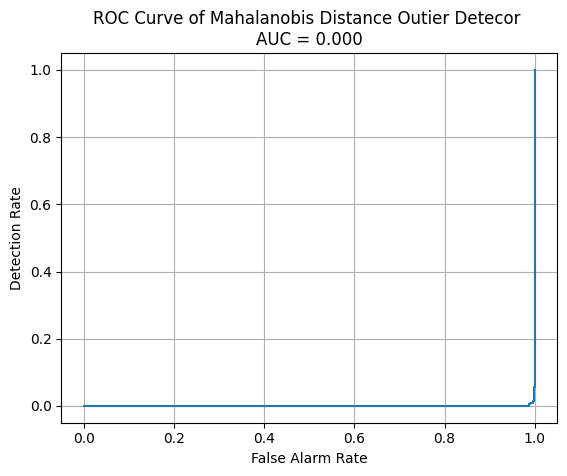

In [106]:
plt.plot(fpr, tpr)
plt.title(f"ROC Curve of Mahalanobis Distance Outier Detecor \nAUC = {auc_score:0.3f}")
plt.grid()
plt.xlabel("False Alarm Rate")
plt.ylabel("Detection Rate")
plt.plot()